In [1]:
import os
import pickle as pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [3]:
TARGET_DIR = './data/target'

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

! echo $CUDA_VISIBLE_DEVICES

0


# 1. Config / Params

In [5]:
batch_size = 32

lr = 0.00001
gamma = 0.99
epochs = 300
epoch_to_record = 150
log_interval = 1
dropout_rate = 0.2

num_classes = 50
shift_cls = 0

model_path = './checkpoints/ir-model-01.pt'

seed = 319

# 2. Dataset & Dataloader

In [6]:
class IrDataset(Dataset):
    def __init__(self, file_name, root_dir, shift_cls, num_classes, transform=None):
        self.df = pd.read_pickle(root_dir + file_name)
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        xs = self.df.iloc[idx]['spectrum'].reshape(1, -1)
        w_cols = [i for i in range(num_classes + 3 + shift_cls, num_classes + 3 + shift_cls + num_classes, 1)]
        ws = self.df.iloc[idx][w_cols].astype('float').values.reshape(-1)
        y_cols = [i for i in range(2 + shift_cls, 2 + shift_cls + num_classes, 1)]
        ys = self.df.iloc[idx][y_cols].astype('float').values.reshape(-1)
        xs = torch.from_numpy(xs).float()
        ys = torch.from_numpy(ys).float()
        ws = torch.from_numpy(ws).float()
        sample = { 
            'xs': xs,
            'ws': ws, 
            'ys': ys 
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [7]:
train_dataset = IrDataset(
    file_name='/df_train.pk',
    root_dir=TARGET_DIR,
    shift_cls=shift_cls,
    num_classes=num_classes
)

valid_dataset = IrDataset(
    file_name='/df_valid.pk',
    root_dir=TARGET_DIR,
    shift_cls=shift_cls,
    num_classes=num_classes
)

test_dataset = IrDataset(
    file_name='/df_test.pk',
    root_dir=TARGET_DIR,
    shift_cls=shift_cls,
    num_classes=num_classes
)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, num_workers=0)

In [9]:
for batch_idx, batch_spl in enumerate(train_loader):
    print(
        batch_idx,
        batch_spl['xs'].size(),
        batch_spl['ws'].size(),
        batch_spl['ys'].size()
    )
    break

0 torch.Size([32, 1, 3400]) torch.Size([32, 50]) torch.Size([32, 50])


# 3. Model

In [10]:
torch.manual_seed(seed)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=11, stride=1, padding=5)
        self.conv1_bn = nn.BatchNorm1d(2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=11, stride=1, padding=5)
        self.conv2_bn = nn.BatchNorm1d(4)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.conv3 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=11, stride=1, padding=5)
        self.conv3_bn = nn.BatchNorm1d(8)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc1 = nn.Linear(3400, 1000)
        self.fc1_bn = nn.BatchNorm1d(1000)
        self.dropout_fc1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(1000, 250)
        self.fc2_bn = nn.BatchNorm1d(250)
        self.dropout_fc2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(250, 64)
        self.fc3_bn = nn.BatchNorm1d(64)
        self.dropout_fc3 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        z = self.conv1_bn(
            F.relu(
                self.conv1(x)
            )
        )
        x = self.dropout1(z)
        x = F.max_pool1d(x, 2)
        
        z = self.conv2_bn(
            F.relu(
                self.conv2(x)
            )
        )
        x = self.dropout2(z)
        x = F.max_pool1d(x, 2)
        
        z = self.conv3_bn(
            F.relu(
                self.conv3(x)
            )
        )
        x = self.dropout3(z)
        x = F.max_pool1d(x, 2)
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.dropout_fc1(x)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.dropout_fc2(x)
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = self.dropout_fc3(x)
        x = self.fc4(x)
        
        output = torch.sigmoid(x)
        
        return output

In [13]:
model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.BCELoss(reduction='none')

scheduler = StepLR(optimizer, step_size=10, gamma=gamma)

# 4. Train / Test processes

In [14]:
train_results = []

def train_process(model, device, data_loader, criterion, optimizer, epoch):
    model.train()
    
    total_loss = 0.0
    counter = 0.0
    for batch_idx, data in enumerate(data_loader):
        xs, ys, ws = data['xs'].to(device), data['ys'].to(device), data['ws'].to(device)
        optimizer.zero_grad()
        
        output = model(xs)
        loss = criterion(output, ys)
        loss = (loss * ws).mean()
        
        total_loss += loss.item()
        counter += 1.0
        
        loss.backward()
        
        optimizer.step()
    
    train_results.append((epoch, total_loss / counter))

In [15]:
verify_results = []
min_verify_loss = 10000

def verify_process(model, device, data_loader, criterion, epoch):
    if epoch % log_interval == 0:
        model.eval()

        ans = []
        with torch.no_grad():
            for data in data_loader:
                xs, ys, ws = data['xs'].to(device), data['ys'].to(device), data['ws'].to(device)
                output = model(xs)
                loss = criterion(output, ys)
                loss = (loss * ws).mean()
                
                ans.append((output, ys))
                
            verify_results.append((epoch, loss.item()))
            
            global epochs
            if epoch >= epoch_to_record:
                global min_verify_loss
                if min_verify_loss > loss:
                    min_verify_loss = loss
                    torch.save(model, model_path)
                    print('Model Save! @ epoch {}, Loss {:.4f}'.format(epoch, loss))
        return ans

# 5. Run

In [16]:
%%time

for epoch in range(epochs):
    train_process(model, device, train_loader, criterion, optimizer, epoch)
    verify_process(model, device, valid_loader, criterion, epoch)
    if epoch % log_interval == 0:
        print(
            'Epoch: {:0>3d}; Train Loss: {:.5f}; Validation Loss: {:.5f}'.format(
                epoch, 
                train_results[-1][1], 
                verify_results[-1][1]
            )
        )
    scheduler.step()

Epoch: 000; Train Loss: 0.73938; Validation Loss: 0.72275
Epoch: 001; Train Loss: 0.71939; Validation Loss: 0.71193
Epoch: 002; Train Loss: 0.70675; Validation Loss: 0.69987
Epoch: 003; Train Loss: 0.69595; Validation Loss: 0.69456
Epoch: 004; Train Loss: 0.68330; Validation Loss: 0.68883
Epoch: 005; Train Loss: 0.67460; Validation Loss: 0.68201
Epoch: 006; Train Loss: 0.66761; Validation Loss: 0.67522
Epoch: 007; Train Loss: 0.66187; Validation Loss: 0.66844
Epoch: 008; Train Loss: 0.64970; Validation Loss: 0.66081
Epoch: 009; Train Loss: 0.64758; Validation Loss: 0.65496
Epoch: 010; Train Loss: 0.64240; Validation Loss: 0.65001
Epoch: 011; Train Loss: 0.63529; Validation Loss: 0.64642
Epoch: 012; Train Loss: 0.62647; Validation Loss: 0.63528
Epoch: 013; Train Loss: 0.62299; Validation Loss: 0.63197
Epoch: 014; Train Loss: 0.61760; Validation Loss: 0.62879
Epoch: 015; Train Loss: 0.61517; Validation Loss: 0.62334
Epoch: 016; Train Loss: 0.60617; Validation Loss: 0.61583
Epoch: 017; Tr

Epoch: 142; Train Loss: 0.29547; Validation Loss: 0.32933
Epoch: 143; Train Loss: 0.29259; Validation Loss: 0.32362
Epoch: 144; Train Loss: 0.29244; Validation Loss: 0.32774
Epoch: 145; Train Loss: 0.29067; Validation Loss: 0.32714
Epoch: 146; Train Loss: 0.29098; Validation Loss: 0.32494
Epoch: 147; Train Loss: 0.28719; Validation Loss: 0.32512
Epoch: 148; Train Loss: 0.28859; Validation Loss: 0.31871
Epoch: 149; Train Loss: 0.28727; Validation Loss: 0.31761
Model Save! @ epoch 150, Loss 0.3213
Epoch: 150; Train Loss: 0.28421; Validation Loss: 0.32133
Model Save! @ epoch 151, Loss 0.3177
Epoch: 151; Train Loss: 0.28049; Validation Loss: 0.31769
Epoch: 152; Train Loss: 0.28214; Validation Loss: 0.32071
Epoch: 153; Train Loss: 0.27966; Validation Loss: 0.32027
Model Save! @ epoch 154, Loss 0.3150
Epoch: 154; Train Loss: 0.27709; Validation Loss: 0.31503
Model Save! @ epoch 155, Loss 0.3129
Epoch: 155; Train Loss: 0.27642; Validation Loss: 0.31290
Model Save! @ epoch 156, Loss 0.3127
Epo

Model Save! @ epoch 259, Loss 0.2515
Epoch: 259; Train Loss: 0.17701; Validation Loss: 0.25154
Epoch: 260; Train Loss: 0.17638; Validation Loss: 0.25638
Epoch: 261; Train Loss: 0.17731; Validation Loss: 0.25766
Epoch: 262; Train Loss: 0.17426; Validation Loss: 0.25390
Epoch: 263; Train Loss: 0.17656; Validation Loss: 0.25260
Epoch: 264; Train Loss: 0.17578; Validation Loss: 0.25495
Epoch: 265; Train Loss: 0.17482; Validation Loss: 0.25554
Epoch: 266; Train Loss: 0.17152; Validation Loss: 0.25823
Model Save! @ epoch 267, Loss 0.2498
Epoch: 267; Train Loss: 0.17301; Validation Loss: 0.24979
Epoch: 268; Train Loss: 0.17169; Validation Loss: 0.25290
Epoch: 269; Train Loss: 0.17181; Validation Loss: 0.25203
Model Save! @ epoch 270, Loss 0.2495
Epoch: 270; Train Loss: 0.17015; Validation Loss: 0.24946
Epoch: 271; Train Loss: 0.17063; Validation Loss: 0.25304
Epoch: 272; Train Loss: 0.17098; Validation Loss: 0.25070
Epoch: 273; Train Loss: 0.16938; Validation Loss: 0.25386
Epoch: 274; Train L

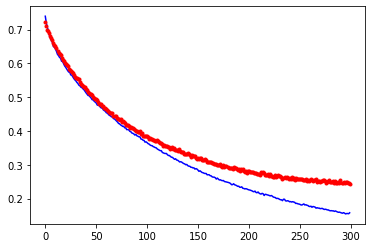

0.24252387881278992

In [17]:
train_loss = [a for e, a in train_results]
train_eps = [e for e, a in train_results]
valid_loss = [a for e, a in verify_results]
valid_eps = [e for e, a in verify_results]
plt.plot(train_eps, train_loss, 'b-')
plt.plot(valid_eps, valid_loss, 'r.')
plt.show()
min(valid_loss)

# 6. Validation

In [18]:
loaded_model = torch.load(model_path)
loaded_model.eval()

Net(
  (conv1): Conv1d(1, 2, kernel_size=(11,), stride=(1,), padding=(5,))
  (conv1_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(2, 4, kernel_size=(11,), stride=(1,), padding=(5,))
  (conv2_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv1d(4, 8, kernel_size=(11,), stride=(1,), padding=(5,))
  (conv3_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=3400, out_features=1000, bias=True)
  (fc1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_fc1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1000, out_features=250, bias=True)
  (fc2_bn): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_fc

In [19]:
ans = verify_process(loaded_model, device, valid_loader, criterion, 0)

yhs, ys = ans[0]

yhs = yhs.cpu().numpy()
ys = ys.cpu().numpy()

fail_valid_idxs = []

count_75 = 0
for nc in range(num_classes):
    t_total, t_correct, t_wrong = 0, 0, 0
    f_total, f_correct, f_wrong = 0, 0, 0

    for idx in range(len(ys)):
        yh, y = yhs[idx][nc], ys[idx][nc]
        if y == 1:
            t_total += 1
            if yh >= 0.5:
                t_correct += 1
            else:
                t_wrong += 1
        else:
            f_total += 1
            if yh < 0.5:
                f_correct += 1
            else:
                f_wrong += 1
    if not t_total:
        print('>>>>>    {} - - - - -'.format(nc))
        continue
    t_acc = t_correct * 100.0 / t_total
    f_acc = f_correct * 100.0 / f_total
    print('FG{:0>2d}; t_acc = {:.2f}% ({}); f_acc = {:.2f}% ({})'.format(
        nc, t_acc, 'O' if t_acc >= 75.0 else 'X', f_acc, 'O' if f_acc >= 75.0 else 'X'))
    if t_acc >= 75.0 and f_acc >= 75.0:
        count_75 += 1
    else:
        fail_valid_idxs.append(nc)
print('number of useful FGs in valid sets (t_acc and f_acc are more than 75%) = ', count_75)

FG00; t_acc = 88.66% (O); f_acc = 93.71% (O)
FG01; t_acc = 86.49% (O); f_acc = 87.25% (O)
FG02; t_acc = 97.14% (O); f_acc = 93.21% (O)
FG03; t_acc = 87.50% (O); f_acc = 83.06% (O)
FG04; t_acc = 89.29% (O); f_acc = 80.06% (O)
FG05; t_acc = 91.84% (O); f_acc = 94.88% (O)
FG06; t_acc = 89.19% (O); f_acc = 90.23% (O)
FG07; t_acc = 84.38% (O); f_acc = 90.58% (O)
FG08; t_acc = 81.08% (O); f_acc = 76.72% (O)
FG09; t_acc = 89.66% (O); f_acc = 96.45% (O)
FG10; t_acc = 96.43% (O); f_acc = 93.76% (O)
FG11; t_acc = 86.67% (O); f_acc = 97.16% (O)
FG12; t_acc = 92.31% (O); f_acc = 94.77% (O)
FG13; t_acc = 96.15% (O); f_acc = 97.31% (O)
FG14; t_acc = 92.59% (O); f_acc = 95.75% (O)
FG15; t_acc = 83.33% (O); f_acc = 90.47% (O)
FG16; t_acc = 88.00% (O); f_acc = 88.56% (O)
FG17; t_acc = 81.48% (O); f_acc = 95.61% (O)
FG18; t_acc = 87.50% (O); f_acc = 91.26% (O)
FG19; t_acc = 80.00% (O); f_acc = 99.72% (O)
FG20; t_acc = 94.44% (O); f_acc = 95.24% (O)
FG21; t_acc = 93.75% (O); f_acc = 96.09% (O)
FG22; t_ac

In [20]:
ans = verify_process(loaded_model, device, test_loader, criterion, 0)

yhs, ys = ans[0]

yhs = yhs.cpu().numpy()
ys = ys.cpu().numpy()

fail_test_idxs = []

count_75 = 0
for nc in range(num_classes):
    t_total, t_correct, t_wrong = 0, 0, 0
    f_total, f_correct, f_wrong = 0, 0, 0

    for idx in range(len(ys)):
        yh, y = yhs[idx][nc], ys[idx][nc]
        if y == 1:
            t_total += 1
            if yh >= 0.5:
                t_correct += 1
            else:
                t_wrong += 1
        else:
            f_total += 1
            if yh < 0.5:
                f_correct += 1
            else:
                f_wrong += 1
    if not t_total:
        print('>>>>>    {} - - - - -'.format(nc))
        continue
    t_acc = t_correct * 100.0 / t_total
    f_acc = f_correct * 100.0 / f_total
    print('FG{:0>2d}; t_acc = {:.2f}% ({}); f_acc = {:.2f}% ({})'.format(
        nc, t_acc, 'O' if t_acc >= 75.0 else 'X', f_acc, 'O' if f_acc >= 75.0 else 'X'))
    if t_acc >= 75.0 and f_acc >= 75.0:
        count_75 += 1
    else:
        fail_test_idxs.append(nc)
print('number of useful FGs in test sets (t_acc and f_acc are more than 75%) = ', count_75)

FG00; t_acc = 95.65% (O); f_acc = 95.36% (O)
FG01; t_acc = 82.72% (O); f_acc = 87.39% (O)
FG02; t_acc = 97.10% (O); f_acc = 93.28% (O)
FG03; t_acc = 88.57% (O); f_acc = 79.82% (O)
FG04; t_acc = 91.07% (O); f_acc = 78.48% (O)
FG05; t_acc = 88.37% (O); f_acc = 93.39% (O)
FG06; t_acc = 90.00% (O); f_acc = 89.84% (O)
FG07; t_acc = 96.88% (O); f_acc = 90.10% (O)
FG08; t_acc = 91.43% (O); f_acc = 75.57% (O)
FG09; t_acc = 93.55% (O); f_acc = 95.76% (O)
FG10; t_acc = 93.55% (O); f_acc = 93.79% (O)
FG11; t_acc = 86.21% (O); f_acc = 95.63% (O)
FG12; t_acc = 96.43% (O); f_acc = 94.09% (O)
FG13; t_acc = 84.85% (O); f_acc = 97.88% (O)
FG14; t_acc = 100.00% (O); f_acc = 95.93% (O)
FG15; t_acc = 96.67% (O); f_acc = 91.96% (O)
FG16; t_acc = 80.00% (O); f_acc = 86.83% (O)
FG17; t_acc = 80.00% (O); f_acc = 96.22% (O)
FG18; t_acc = 77.27% (O); f_acc = 91.35% (O)
FG19; t_acc = 84.21% (O); f_acc = 99.58% (O)
FG20; t_acc = 88.24% (O); f_acc = 95.43% (O)
FG21; t_acc = 72.22% (X); f_acc = 95.28% (O)
FG22; t_a

# 7. Performance

In [21]:
fail_valid_idxs

[29, 31, 42]

In [22]:
fail_test_idxs

[21, 22, 31, 34, 38, 45, 47]

In [23]:
len(set(fail_valid_idxs + fail_test_idxs))

9

In [24]:
set(fail_valid_idxs + fail_test_idxs)

{21, 22, 29, 31, 34, 38, 42, 45, 47}